# Plot the sncosmo fit with DECam DDF nightly-epoch photometry

Should have pickled the fitted model or something as part of notebook 2...
but we didn't, so just redo the fit using the same redshift inputs.

Then create a single multi-band plot with the multi-band fit SNIa light curve.

Save the multi-band plot to `2_all_potential_snia_fits/multiband_fit_plots/`. 

In [1]:
import sncosmo
import iminuit
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.backends.backend_pdf import PdfPages

**Define the name of the candidate to be plotted.**

In [2]:
use_candidate = 'DC22iykha'

Set up the model and plotting parameters.

In [3]:
model = sncosmo.Model(source='salt2')
zeropoint = 31.4

In [4]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [5]:
all_filters = ['g','r','i']
all_fcolors = ['green','red','blue']
all_fshapes = ['o','s','^']
all_fsizes  = [5, 5, 7]

Read the relevant data files.

In [6]:
fnm = '../all_nightly_epochs_files/candidate_lightcurves.dat'
candLC_field = np.loadtxt(fnm, dtype='str', usecols=(0))
candLC_candid = np.loadtxt(fnm, dtype='str', usecols=(1))
candLC_caldate = np.loadtxt(fnm, dtype='str', usecols=(2))
candLC_mjd = np.loadtxt(fnm, dtype='float', usecols=(3))
candLC_filter = np.loadtxt(fnm, dtype='str', usecols=(4))
candLC_Nobj = np.loadtxt(fnm, dtype='int', usecols=(5))
candLC_mag = np.loadtxt(fnm, dtype='float', usecols=(6))
candLC_mage = np.loadtxt(fnm, dtype='float', usecols=(7))
candLC_mrb = np.loadtxt(fnm, dtype='float', usecols=(8))
candLC_lef = np.loadtxt(fnm, dtype='float', usecols=(9))
del fnm

In [7]:
fnm = '2_all_potential_snia_fits/results_sncosmos.dat'
fit_cand = np.loadtxt(fnm, dtype='str', usecols=(0))
fit_est_z = np.loadtxt(fnm, dtype='float', usecols=(1))
fit_in_zlo = np.loadtxt(fnm, dtype='float', usecols=(2))
fit_in_zhi = np.loadtxt(fnm, dtype='float', usecols=(3))
fit_z = np.loadtxt(fnm, dtype='float', usecols=(4))
fit_ze = np.loadtxt(fnm, dtype='float', usecols=(5))
fit_t0 = np.loadtxt(fnm, dtype='float', usecols=(6))
fit_t0e = np.loadtxt(fnm, dtype='float', usecols=(7))
fit_x0 = np.loadtxt(fnm, dtype='float', usecols=(8))
fit_x0e = np.loadtxt(fnm, dtype='float', usecols=(9))
fit_x1 = np.loadtxt(fnm, dtype='float', usecols=(10))
fit_x1e = np.loadtxt(fnm, dtype='float', usecols=(11))
fit_c = np.loadtxt(fnm, dtype='float', usecols=(12))
fit_ce = np.loadtxt(fnm, dtype='float', usecols=(13))
fit_pmB = np.loadtxt(fnm, dtype='float', usecols=(14))
fit_pmg = np.loadtxt(fnm, dtype='float', usecols=(15))
fit_pmr = np.loadtxt(fnm, dtype='float', usecols=(16))
fit_pmi = np.loadtxt(fnm, dtype='float', usecols=(17))
del fnm

Create a light curve file in the format expected by `sncosmo`, then read it in with `sncosmo`.

In [8]:
px = np.where((candLC_candid == use_candidate) & (candLC_lef == 0))[0]
fout = open('temp_sncosmo.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
for x in px:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - zeropoint)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - zeropoint)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f %5.1f ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe, zeropoint))
fout.close()
del px

In [9]:
data = sncosmo.read_lc('temp_sncosmo.txt')

In [10]:
# data

Run the fit with `sncosmo`, use the same input redshift boundaries as in notebook 2.

In [11]:
cx = np.where(fit_cand == use_candidate)[0]
result, fitted_model = sncosmo.fit_lc(data, model, ['z', 't0', 'x0', 'x1', 'c'], 
                                      bounds={'z':(fit_in_zlo[cx[0]], fit_in_zhi[cx[0]])})
del cx

In [12]:
# result

In [13]:
# fitted_model

Create the multi-band light curve plot with the fits.

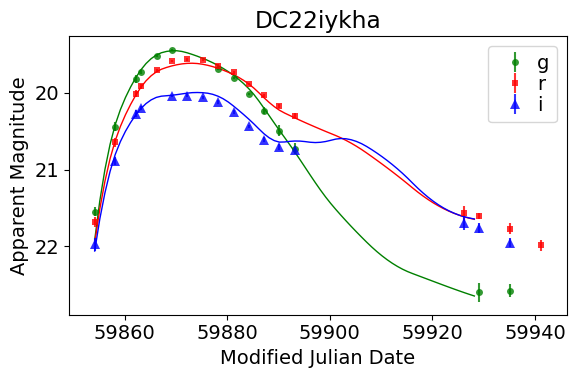

In [14]:
fig = plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 14})

px = np.where(candLC_candid == use_candidate)[0]
xmin = np.min(candLC_mjd[px])
xmax = np.max(candLC_mjd[px])
del px

fit_x = np.arange(np.ceil(xmax-xmin), dtype='float') + xmin

for f, filt in enumerate(all_filters):
    cx0 = np.where((candLC_candid == use_candidate) & (candLC_filter == filt) & 
                   (candLC_mrb > 0.4))[0]
    cx1 = np.where((candLC_candid == use_candidate) & (candLC_filter == filt) & 
                   (candLC_mrb <= 0.4) & (candLC_lef == 0))[0]
    cx2 = np.where((candLC_candid == use_candidate) & (candLC_filter == filt) & 
                   (candLC_mrb <= 0.4) & (candLC_lef == 1))[0]
    if(len(cx0) > 0):
        # plt.plot(candLC_mjd[cx0], candLC_mag[cx0], all_fshapes[f], ms=all_fsizes[f], 
        #          mew=0, alpha=0.8, color=all_fcolors[f], label=filt)
        plt.errorbar(candLC_mjd[cx0], candLC_mag[cx0], yerr=candLC_mage[cx0],
                     fmt=all_fshapes[f], ms=all_fsizes[f], mew=0, alpha=0.8, color=all_fcolors[f], label=filt)
    if(len(cx1) > 0):
        plt.plot(candLC_mjd[cx1], candLC_mag[cx1], all_fshapes[f], ms=all_fsizes[f], 
                 mew=1, alpha=0.8, color='none', mec=all_fcolors[f], label=filt+' (R/B<0.4)')
    if(len(cx2) > 0):
        plt.plot(candLC_mjd[cx2], candLC_mag[cx2], all_fshapes[f], ms=all_fsizes[f]-1, 
                 mew=0, alpha=0.4, color=all_fcolors[f])
    del cx0, cx1, cx2
    
    sdss_band = 'sdss' + filt
    fit_m = np.zeros(len(fit_x), dtype='float')
    for x, day in enumerate(fit_x):
        fit_m[x] = fitted_model.bandmag(sdss_band, 'ab', day)
    plt.plot(fit_x, fit_m, lw=1, color=all_fcolors[f])
    del fit_m

plt.gca().invert_yaxis()
plt.title(use_candidate)
plt.legend(loc='best', labelspacing=0.1, handletextpad=0.1, fontsize=14)
plt.xlim([xmin - 5.0, xmax + 5.0])
del xmin, xmax

plt.xlabel('Modified Julian Date', fontsize=14)
plt.ylabel('Apparent Magnitude', fontsize=14)

fig.tight_layout()
plt.savefig('2_all_potential_snia_fits/multiband_fit_plots/fit_multiband_'+use_candidate)
plt.show()

Read in the links from the file of handy links and print them for this candidate for quick reference.

In [15]:
fnm = '../cross_matched_LSDR10/candidate_links.dat'
link_candid = np.loadtxt(fnm, dtype='str', usecols=(0))
link_lsview = np.loadtxt(fnm, dtype='str', usecols=(1))
link_rkview = np.loadtxt(fnm, dtype='str', usecols=(2))
cx = np.where(link_candid == use_candidate)[0]
print(link_lsview[cx[0]])
print(link_rkview[cx[0]])
del fnm, cx

https://www.legacysurvey.org/viewer/cutout.jpg?ra=8.65400944720007&dec=-43.2936812958176&layer=ls-dr9&pixscale=0.06
https://decat-webap.lbl.gov/decatview.py/cand/DC22iykha
